# Model training

In [39]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [38]:
# Load dataset
heart_dataset = pd.read_csv('heart_dataset_preprocessed.csv')

# Split dataset
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

## Method for ROC plotting

In [21]:
def plot_roc(estimator_name, y_test, y_predicted):
    figure = plt.figure()
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic (ROC) - '+estimator_name)

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)

    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return figure

## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

{'accuracy': 0.842691710357623,
 'recall': 0.08854041013268998,
 'precision': 0.08875453446191052,
 'f1_score': 0.08864734299516909}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

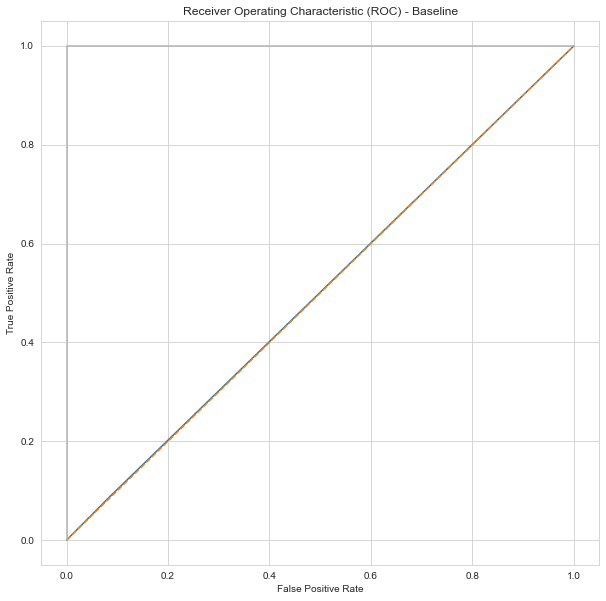

In [37]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)
results_dict = {'accuracy': accuracy_score(y_test, y_predicted),
                'recall': recall_score(y_test, y_predicted),
                'precision': precision_score(y_test, y_predicted),
                'f1_score': f1_score(y_test, y_predicted)}
display(results_dict)

plot_roc("Baseline", y_test, y_predicted)

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Modelling and evaluation method

Function that generate different models and evaluate them

In [50]:
scorer = make_scorer(fbeta_score, beta=2)
print(scorer)

# BL: why are you passing scoring and verbose as parameter when both values are set in the method signature?
def model_eval(estimator, parameters, X, y, scoring=scorer, verbose=0):
    # specify the cross validation
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator,
                                         param_grid=parameters,
                                         scoring=scoring,
                                         cv=inner_cv,
                                         return_train_score=False,
                                         verbose=verbose
                                         )


    nested_cv_score = cross_validate(grid_search_estimator,
                                     X=X, y=y,
                                     verbose=verbose,
                                     cv=outer_cv, scoring=scorer)

    #     display(nested_cv_score.mean())
    return nested_cv_score

make_scorer(fbeta_score, beta=2)


## Knn

In [51]:
# create an estimator
knn_estimator = KNeighborsClassifier()

# specify the parameter grid
parameters = {
    'n_neighbors': [2, 3, 5]
}

# train model
knn_result = model_eval(estimator=knn_estimator, parameters=parameters, X=X, y=y)

# results
print("Mean", knn_result['test_score'].mean())
for score in knn_result['test_score']:
    print(score)

/Users/benediktluth/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/benediktluth/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/benediktluth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/Users/benediktluth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 400, in _fit
  

NotFittedError: All estimators failed to fit

## Random Forest

In [42]:
# create an estimator
forest_estimator = RandomForestClassifier()

# specify the parameter grid
parameters = {
    'n_estimators': [2, 3, 4, 5]
}

# train model
forest_result = model_eval(estimator=forest_estimator, parameters=parameters, X=X, y=y)

# results
print("Mean", forest_result['test_score'].mean())
for score in forest_result['test_score']:
    print(score)

/Users/benediktluth/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 16.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/benediktluth/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/benediktluth/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/Users/benediktluth/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data
    X, 

NotFittedError: All estimators failed to fit

## Support Vector Machine

In [167]:
# create an estimator
svc_estimator = SVC(random_state=0)

# specify the parameter grid
parameters = {
    'kernel': ['linear', 'poly']
}

# train model
svc_result = model_eval(estimator=svc_estimator, parameters=parameters, X=X, y=y)

# results
print("Mean", svc_result['test_score'].mean())
for score in svc_result['test_score']:
    print(score)

## Neural Net

In [169]:
# create an estimator
nn_estimator = MLPClassifier(random_state=1, max_iter=300)

# specify the parameter grid
parameters = {
    'activation': ['identity', 'logistic', 'tanh', 'relu']
}

# train model
nn_result = model_eval(estimator=nn_estimator, parameters=parameters, X=X, y=y)

# results
print("Mean", nn_result['test_score'].mean())
for score in nn_result['test_score']:
    print(score)

C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multi